## Reference Model

In [1]:
import maxentep
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.19801219, 0.16732211, 0.42503969, 0.20962601],
        [0.50148645, 0.12091214, 0.21414158, 0.16345983],
        [0.22987062, 0.01633422, 0.43502866, 0.3187665 ],
        [0.2720602 , 0.13058982, 0.3013417 , 0.29600828]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 2)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 4)

In [4]:
start = np.zeros((M, C))
start[0, 0] = 0.1

In [5]:
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, 250)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



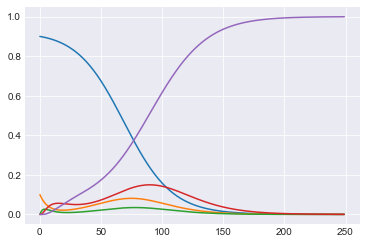

In [6]:
ref_traj = model(R, tmat.value, start, 0.1)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [7]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'I', 7, 2)
tmat.add_transition('I', 'R', 4, 4)

In [8]:
param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R * 0.8, tmat, name='unbiased_model')

In [9]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
outs = []
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, 250)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]

(8192, 250, 4, 4)


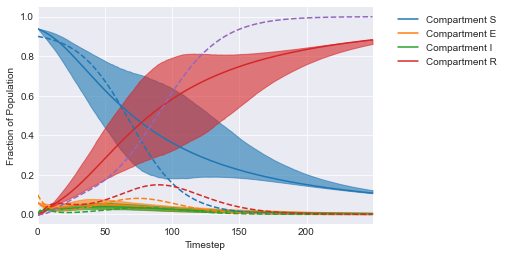

In [10]:
full_compartments = ['S'] + compartments
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [11]:
npoints = 5
prior = maxentep.Laplace(0.1)
#prior = maxentep.EmptyPrior() # can try empty to compare with regressed
restraints, plot_fxns = maxentep.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.05)

31 0.09592235 0.061772035424191594
17 0.043600075 0.03502915537245081
59 0.22737877 0.2909657367383007
66 0.27860132 0.2659085167985629
38 0.12160505 0.13687450851192814


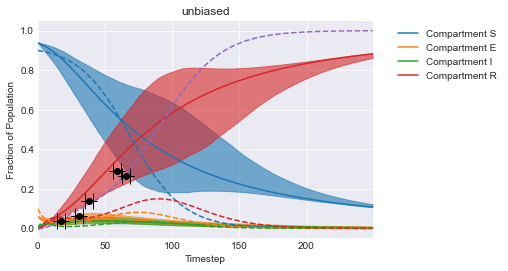

In [12]:
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [13]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [14]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [15]:
history = me_model.fit(trajs, batch_size=8,epochs=10, callbacks=[CustomCallback()])

Epoch 1/10
1024/1024 [==============================] - 1s 633us/step - loss: 0.0047 - weight-entropy: 1.9914
Epoch 2/10
1024/1024 [==============================] - 1s 581us/step - loss: 0.0045 - weight-entropy: 1.9832
Epoch 3/10
1024/1024 [==============================] - 1s 609us/step - loss: 0.0042 - weight-entropy: 1.9857
Epoch 4/10
1024/1024 [==============================] - 1s 672us/step - loss: 0.0039 - weight-entropy: 1.9861
Epoch 5/10
1024/1024 [==============================] - 1s 636us/step - loss: 0.0042 - weight-entropy: 1.9821
Epoch 6/10
1024/1024 [==============================] - 1s 697us/step - loss: 0.0043 - weight-entropy: 1.9796
Epoch 7/10
1024/1024 [==============================] - ETA: 0s - loss: 0.0043 - weight-entropy: 1.98 - 1s 662us/step - loss: 0.0043 - weight-entropy: 1.9814
Epoch 8/10
1024/1024 [==============================] - 1s 669us/step - loss: 0.0042 - weight-entropy: 1.98210s - loss: 0.0046 - 
Epoch 9/10
1024/1024 [==============================

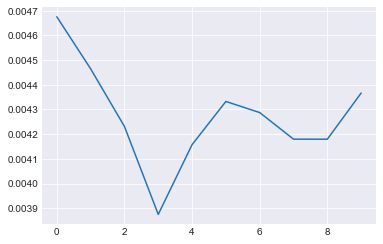

In [16]:
plt.plot(history.history['loss'])

## Using Algorithm 2

In [17]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R, tmat, name='unbiased_model')
fit_param_model.compile(tf.optimizers.Adam(0.1))
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [18]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=25, batch_size=32, epochs=8)

Epoch 1/8
16/16 [==============================] - 0s 687us/step - loss: 0.0037 - weight-entropy: 3.4367
Epoch 2/8
16/16 [==============================] - 0s 687us/step - loss: 0.0022 - weight-entropy: 3.4097
Epoch 3/8
16/16 [==============================] - 0s 812us/step - loss: 0.0020 - weight-entropy: 3.3834
Epoch 4/8
16/16 [==============================] - 0s 812us/step - loss: 0.0013 - weight-entropy: 3.3691
Epoch 5/8
16/16 [==============================] - 0s 687us/step - loss: 0.0020 - weight-entropy: 3.3674
Epoch 6/8
16/16 [==============================] - 0s 687us/step - loss: 0.0013 - weight-entropy: 3.3657
Epoch 7/8
16/16 [==============================] - 0s 687us/step - loss: 0.0016 - weight-entropy: 3.3669
Epoch 8/8
16/16 [==============================] - 0s 625us/step - loss: 0.0015 - weight-entropy: 3.3664
Epoch 1/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1116 - R-dist-dist_loss: 0.0100 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0

16/16 [==============================] - 0s 812us/step - loss: 0.0015 - weight-entropy: 3.3018
Epoch 6/8
16/16 [==============================] - 0s 750us/step - loss: 0.0020 - weight-entropy: 3.3071
Epoch 7/8
16/16 [==============================] - 0s 812us/step - loss: 0.0011 - weight-entropy: 3.2989
Epoch 8/8
16/16 [==============================] - 0s 750us/step - loss: 0.0018 - weight-entropy: 3.3046
Epoch 1/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1084 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0046 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1108
Epoch 2/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1086 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1110
Epoch 3/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1082 - R-dist-dist_loss: 0.0098 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1106
Epoch 4/8
16/16 [===

16/16 [==============================] - 0s 1ms/step - loss: -0.1104 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1126
Epoch 5/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1102 - R-dist-dist_loss: 0.0100 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1125
Epoch 6/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1105 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1128
Epoch 7/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1103 - R-dist-dist_loss: 0.0100 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1126
Epoch 8/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1104 - R-dist-dist_loss: 0.0100 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1127
Epoch 1/8
16/16 [==============================] - 0s 813us/

16/16 [==============================] - 0s 1ms/step - loss: -0.1065 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0029 - beta-dist_loss: -0.1085
Epoch 1/8
16/16 [==============================] - 0s 875us/step - loss: 0.0023 - weight-entropy: 3.3208
Epoch 2/8
16/16 [==============================] - 0s 750us/step - loss: 9.8738e-04 - weight-entropy: 3.3203
Epoch 3/8
16/16 [==============================] - 0s 750us/step - loss: 0.0018 - weight-entropy: 3.3131
Epoch 4/8
16/16 [==============================] - 0s 687us/step - loss: 0.0021 - weight-entropy: 3.3138
Epoch 5/8
16/16 [==============================] - 0s 750us/step - loss: 0.0013 - weight-entropy: 3.3084
Epoch 6/8
16/16 [==============================] - 0s 813us/step - loss: 0.0014 - weight-entropy: 3.3123
Epoch 7/8
16/16 [==============================] - 0s 812us/step - loss: 0.0015 - weight-entropy: 3.3118
Epoch 8/8
16/16 [==============================] - 0s 750us/step - loss: 0.0019 -

16/16 [==============================] - 0s 1ms/step - loss: -0.1073 - R-dist-dist_loss: 0.0094 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1090
Epoch 2/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1074 - R-dist-dist_loss: 0.0094 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1091
Epoch 3/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1072 - R-dist-dist_loss: 0.0093 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1089
Epoch 4/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1074 - R-dist-dist_loss: 0.0093 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1090
Epoch 5/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1073 - R-dist-dist_loss: 0.0093 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1090
Epoch 6/8
16/16 [==============================] - 0s 1ms/st

16/16 [==============================] - 0s 1ms/step - loss: -0.1104 - R-dist-dist_loss: 0.0098 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1124
Epoch 7/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1103 - R-dist-dist_loss: 0.0098 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1124
Epoch 8/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1099 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1120
Epoch 1/8
16/16 [==============================] - 0s 812us/step - loss: 0.0021 - weight-entropy: 3.2349
Epoch 2/8
16/16 [==============================] - 0s 813us/step - loss: 0.0014 - weight-entropy: 3.2252
Epoch 3/8
16/16 [==============================] - 0s 813us/step - loss: 0.0015 - weight-entropy: 3.2351
Epoch 4/8
16/16 [==============================] - 0s 750us/step - loss: 0.0017 - weight-entropy: 3.2364
Epoch 5/8
16/16 [===

16/16 [==============================] - 0s 625us/step - loss: 0.0012 - weight-entropy: 3.2483
Epoch 4/8
16/16 [==============================] - 0s 687us/step - loss: 0.0015 - weight-entropy: 3.2441
Epoch 5/8
16/16 [==============================] - 0s 687us/step - loss: 0.0021 - weight-entropy: 3.2416
Epoch 6/8
16/16 [==============================] - 0s 750us/step - loss: 0.0016 - weight-entropy: 3.2450
Epoch 7/8
16/16 [==============================] - 0s 750us/step - loss: 0.0013 - weight-entropy: 3.2479
Epoch 8/8
16/16 [==============================] - 0s 625us/step - loss: 0.0014 - weight-entropy: 3.2390
Epoch 1/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1073 - R-dist-dist_loss: 0.0101 - T-dist-dist_loss: -0.0045 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1100
Epoch 2/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1068 - R-dist-dist_loss: 0.0101 - T-dist-dist_loss: -0.0046 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1094


16/16 [==============================] - 0s 1ms/step - loss: -0.1066 - R-dist-dist_loss: 0.0098 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1085
Epoch 4/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1060 - R-dist-dist_loss: 0.0097 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1078
Epoch 5/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1068 - R-dist-dist_loss: 0.0097 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1085
Epoch 6/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1067 - R-dist-dist_loss: 0.0097 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1085
Epoch 7/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1065 - R-dist-dist_loss: 0.0097 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1082
Epoch 8/8
16/16 [==============================] - 0s 1ms/st

In [19]:
history.history.keys()

dict_keys(['loss', 'weight-entropy', 'prior-loss', 'prior-R-dist-dist_loss', 'prior-T-dist-dist_loss', 'prior-rho-dist-dist_loss', 'prior-beta-dist_loss'])

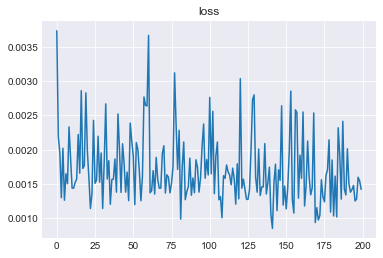

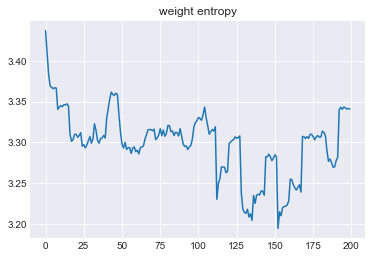

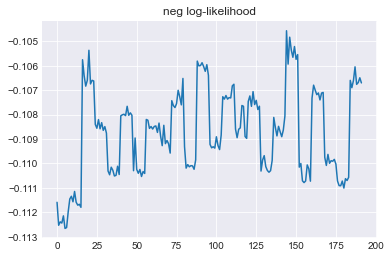

In [20]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

In [21]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.4469154]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3025851]], dtype=float32)>])

In [22]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_2[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 4, 4)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_2[0][0]                    
_______________________________________________________________________________

In [23]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([-0.5093425 ,  0.10215282,  0.09018416,  0.2674945 ], dtype=float32)>],
 [<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>])

In [24]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[ 0.02789938  0.00283955 -0.03845214  0.03191993 -0.01243822] [ 0.01800403  0.00027976 -0.06905627 -0.00235454 -0.02755725]
0.00068771944 0.0011715873


In [25]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 8.892736 after tuning 8.884505


## Direct Regression of Model

In [26]:
T = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.5
infect = maxentep.ContactInfectionLayer(0.1, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R, T, infect, 250, agreement)

In [27]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(100)
rtraj = rmodel.get_traj()

100/100 [==============================] - 10s 96ms/step - loss: 0.0379 - output_2_loss: 0.0379


## Now visualize results

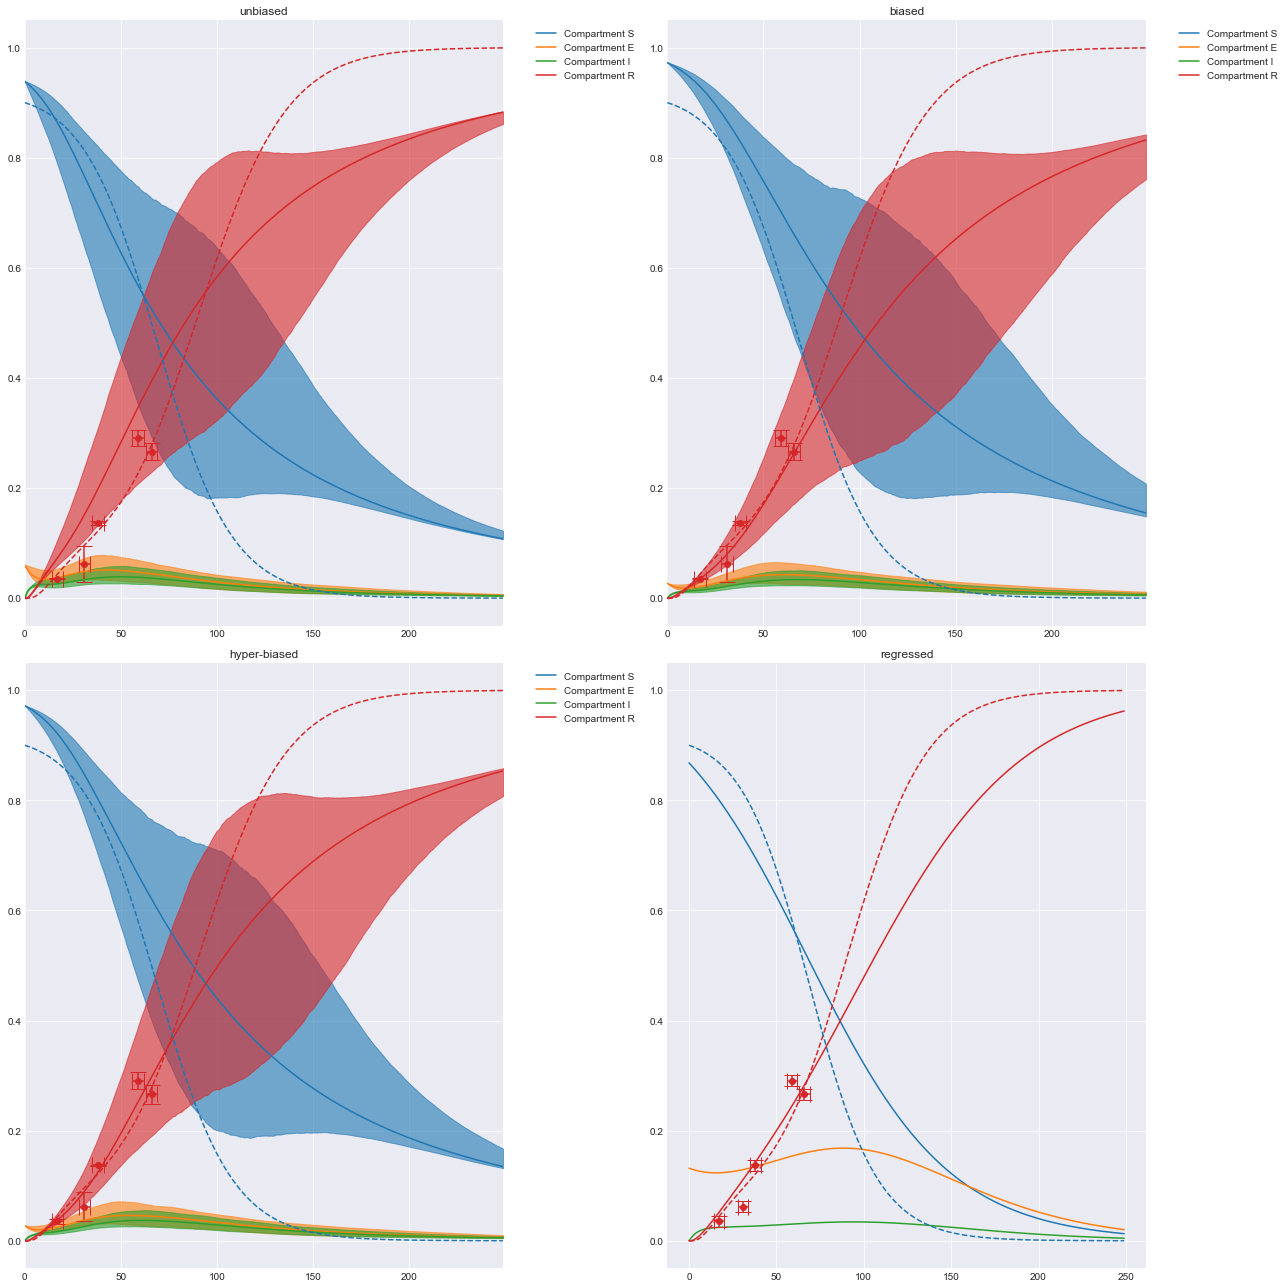

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,0,:])
axs[1,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('traj_match.png', dpi=300)
plt.show()

## Other Patch

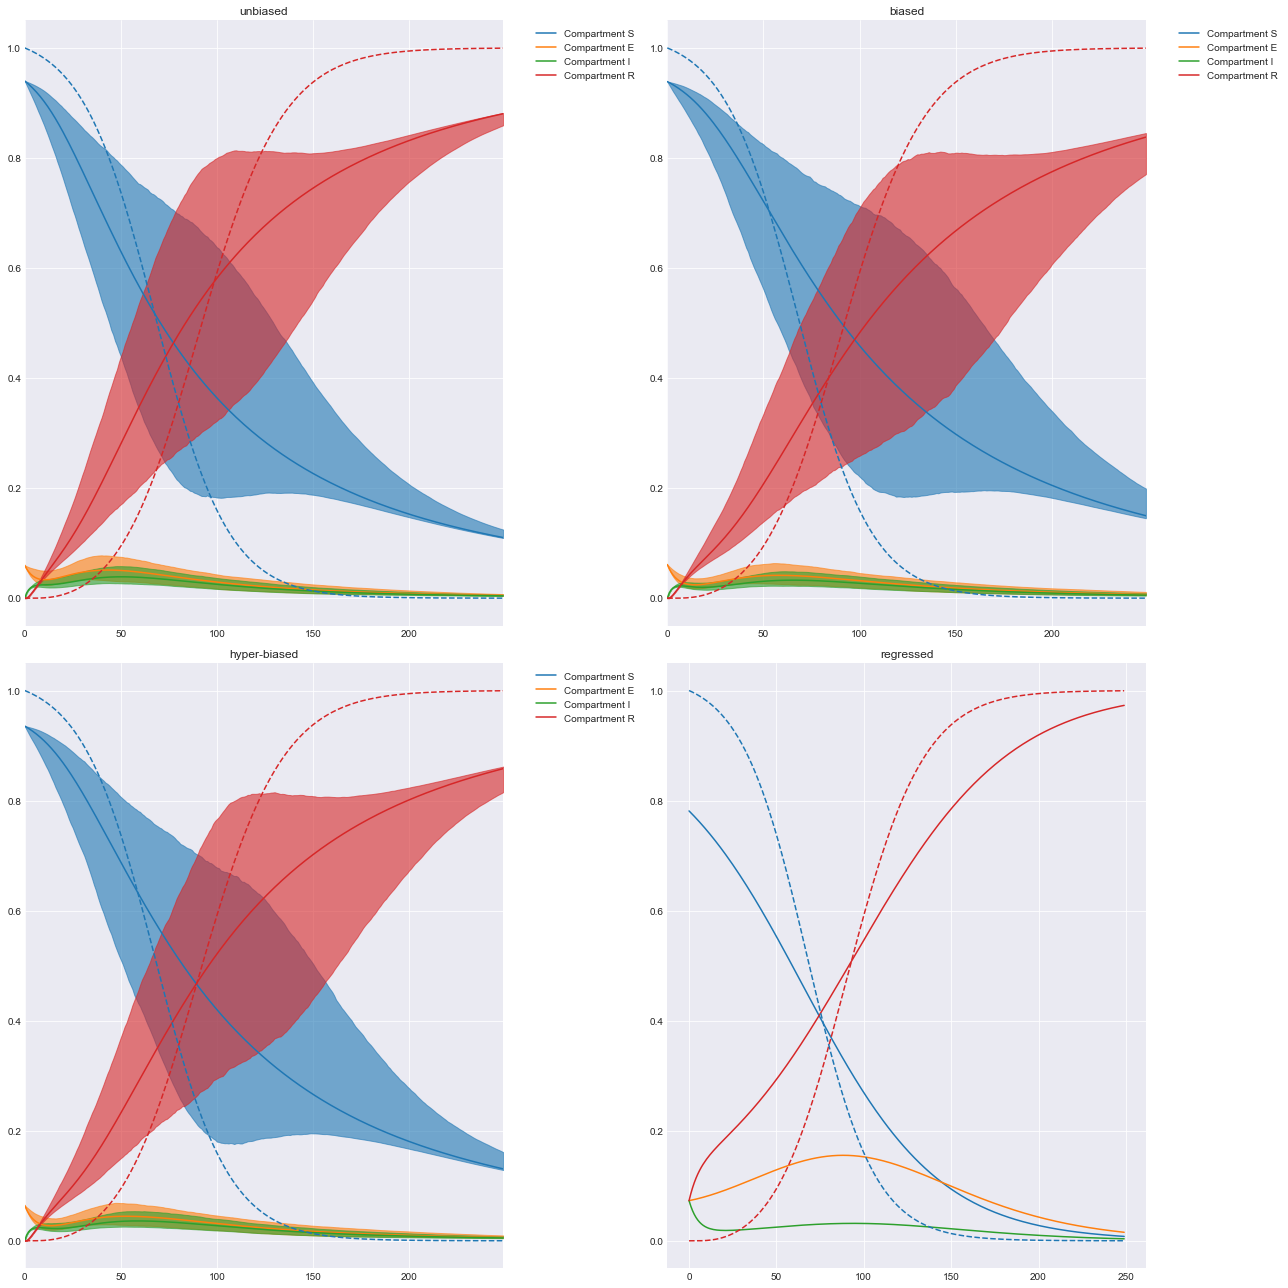

In [29]:
patch = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch,:])
axs[1,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

plt.tight_layout()
plt.savefig(f'traj_match_patch_{patch}.png', dpi=300)
plt.show()